In [192]:
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib as plt
import pandas as pd
import numpy as np
import time

In [194]:
df = pd.read_csv('leg4_combined.csv')
df.isnull().any()
df['PCO2.H2O_mmm'] = df['PCO2.H2O_mmm'].astype(float)
df.dtypes

LATITUDE                        float64
LONGITUD                        float64
PDMEAN                          float64
TOTAL                           float64
dataid                            int64
PCO2.H2O_mmm                    float64
PCO2.CO2_umm                    float64
PCO2.atm_cond                   float64
NMEA.Humidity                   float64
NMEA.Trykk                      float64
FerryBox.SBE45_Salinity         float64
FerryBox.SBE45_Conductivity     float64
FerryBox.Optode_Saturation      float64
FerryBox.C3_Turbidity           float64
FerryBox.C3_CHLAFluorescence    float64
FerryBox.C3_Temperature         float64
FerryBox.C3_CDOMFluorescence    float64
dtype: object

In [107]:
# Fill NaNs with median value of the column
df = df.fillna(df.median())


In [109]:
y = df.iloc[:, df.columns == 'TOTAL']
X = df.iloc[:, df.columns != 'TOTAL']

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Feature: LATITUDE, Score: 0.13205
Feature: LONGITUD, Score: 0.06960
Feature: PDMEAN, Score: 0.35393
Feature: dataid, Score: 0.14094
Feature: PCO2.H2O_mmm, Score: 0.00149
Feature: PCO2.CO2_umm, Score: 0.00142
Feature: PCO2.atm_cond, Score: 0.00038
Feature: NMEA.Humidity, Score: 0.02705
Feature: NMEA.Trykk, Score: 0.02357
Feature: FerryBox.SBE45_Salinity, Score: 0.03608
Feature: FerryBox.SBE45_Conductivity, Score: 0.05059
Feature: FerryBox.Optode_Saturation, Score: 0.05743
Feature: FerryBox.C3_Turbidity, Score: 0.05878
Feature: FerryBox.C3_CHLAFluorescence, Score: 0.01408
Feature: FerryBox.C3_Temperature, Score: 0.01188
Feature: FerryBox.C3_CDOMFluorescence, Score: 0.02073


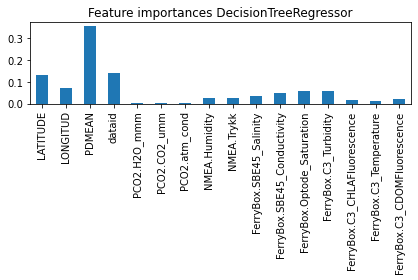

In [190]:
# define the model
model = DecisionTreeRegressor()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print(f'Feature: %s, Score: %.5f' % (X.columns[i],v))
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
importances = pd.Series(importance, index=X.columns)

fig, ax = pyplot.subplots()
importances.plot.bar([x for x in range(len(importance))], importance)
ax.set_title("Feature importances DecisionTreeRegressor")
fig.tight_layout()
pyplot.show()


In [146]:
for name, importance in zip(X.columns, model.feature_importances_):
    print(name, importance)

LATITUDE 0.1802756933587077
LONGITUD 0.12701681758443722
PDMEAN 0.3539074400745287
dataid 0.06524724140512912
PCO2.H2O_mmm 0.0012525868046905381
PCO2.CO2_umm 0.001372397215185508
PCO2.atm_cond 0.0013355049813621343
NMEA.Humidity 0.024891551385000807
NMEA.Trykk 0.020409025880278885
FerryBox.SBE45_Salinity 0.03818368254539865
FerryBox.SBE45_Conductivity 0.02035285903114357
FerryBox.Optode_Saturation 0.056682710521788325
FerryBox.C3_Turbidity 0.0593351661058852
FerryBox.C3_CHLAFluorescence 0.015691932378108207
FerryBox.C3_Temperature 0.012612671659492257
FerryBox.C3_CDOMFluorescence 0.02143271906886315


In [148]:
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train, y_train.values.ravel())
start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.089 seconds


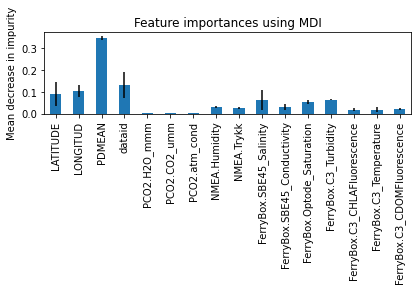

In [149]:
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = pyplot.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [159]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=X.columns)

Elapsed time to compute the importances: 59.302 seconds


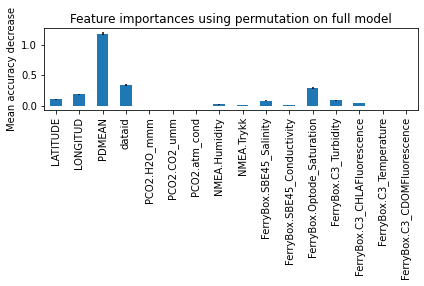

In [161]:
fig, ax = pyplot.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
pyplot.show()

In [170]:
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Text(0.5, 1.0, 'Total')

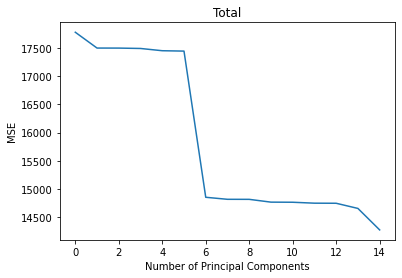

In [191]:
#scale predictor variables
pca = PCA()
X_reduced = pca.fit_transform(scale(X_train))

#define cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []

# Calculate MSE with only the intercept
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y_train, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using cross-validation, adding one component at a time
for i in np.arange(1, 15):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y_train, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
pyplot.plot(mse)
pyplot.xlabel('Number of Principal Components')
pyplot.ylabel('MSE')
pyplot.title('Total')

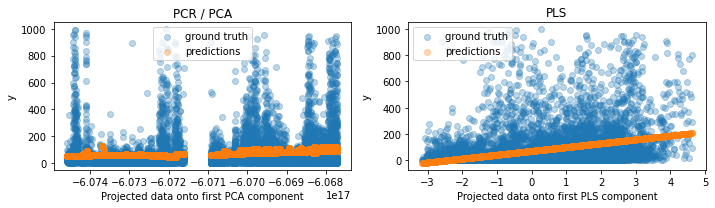

In [181]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
pcr.fit(X_train, y_train)
pca2 = pcr.named_steps["pca"]  # retrieve the PCA step of the pipeline

pls = PLSRegression(n_components=1)
pls.fit(X_train, y_train)

fig, axes = pyplot.subplots(1, 2, figsize=(10, 3))
axes[0].scatter(pca2.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[0].scatter(
    pca2.transform(X_test), pcr.predict(X_test), alpha=0.3, label="predictions"
)
axes[0].set(
    xlabel="Projected data onto first PCA component", ylabel="y", title="PCR / PCA"
)
axes[0].legend()
axes[1].scatter(pls.transform(X_test), y_test, alpha=0.3, label="ground truth")
axes[1].scatter(
    pls.transform(X_test), pls.predict(X_test), alpha=0.3, label="predictions"
)
axes[1].set(xlabel="Projected data onto first PLS component", ylabel="y", title="PLS")
axes[1].legend()
pyplot.tight_layout()
pyplot.show()

In [178]:
print(f"PCR r-squared {pcr.score(X_test, y_test):.3f}")
print(f"PLS r-squared {pls.score(X_test, y_test):.3f}")

PCR r-squared 0.015
PLS r-squared 0.101
